# Stage 3 모델 비교 실험: CLAM vs CAMIL vs Baseline MIL (Baseline 설정)

이 노트북은 Stage 2에서 생성한 MIL Bag 데이터를 입력으로 받아 세 가지 MIL 모델을 비교 실험합니다:
1. **기본 Attention MIL**: 단순한 attention mechanism (베이스라인)
2. **CLAM**: Clustering-constrained Attention MIL - 클러스터링 제약을 통한 attention 개선
3. **CAMIL**: Channel Attention MIL - 채널별 attention을 활용한 향상된 모델

**실험 목표:**
- 세 모델의 성능 비교
- Clustering constraint와 Channel attention의 효과 검증
- 모델별 attention pattern 분석

**⚠️ 중요: 공정한 비교를 위해 baseline 설정으로 통일**
- 손실 함수: `WeightedBCE(fp_weight=2.0)` (baseline과 동일하게 변경)
- 최대 에포크: 10 (baseline과 동일)
- Early Stopping Patience: 3 (baseline과 동일)
- Scheduler Patience: 1 (baseline과 동일)

In [1]:
# 환경 설정
import os
import random
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve, confusion_matrix
from tqdm import tqdm

# GPU 설정
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = os.getenv('MIL_STAGE3_GPU', '3')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if device.type == 'cuda':
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('CUDA를 사용할 수 없습니다. CPU 모드로 실행됩니다.')

# 시드 고정 유틸리티 함수
def seed_everything(seed=42):
    """모든 난수 생성기 시드를 고정하는 함수"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"🔒 모든 시드를 {seed}로 고정완료")

# 초기 시드 고정
seed_everything(42)

Using device: cuda
GPU: NVIDIA GeForce RTX 3090
🔒 모든 시드를 42로 고정완료


In [2]:
# Stage 2 Bag 데이터 로드 및 Instance 평균 계산
embedding_margin = '0.4'
bags_dir = '/workspace/MIL/data/processed/bags'
train_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{embedding_margin}_50p_random_train.pkl')
val_pkl   = os.path.join(bags_dir, f'bags_arcface_margin_{embedding_margin}_50p_random_val.pkl')
test_pkl  = os.path.join(bags_dir, f'bags_arcface_margin_{embedding_margin}_50p_random_test.pkl')

print('Loading MIL bags...')
with open(train_pkl, 'rb') as f:
    train_data = pickle.load(f)
with open(val_pkl, 'rb') as f:
    val_data = pickle.load(f)
with open(test_pkl, 'rb') as f:
    test_data = pickle.load(f)

# Instance mean 계산: (10,5,256) → (10,256)
def to_instance_means(bags):
    return [bag.mean(axis=1).astype(np.float32) for bag in bags]

train_features = to_instance_means(train_data['bags'])
val_features   = to_instance_means(val_data['bags'])
test_features  = to_instance_means(test_data['bags'])

train_labels = train_data['labels']
val_labels   = val_data['labels']
test_labels  = test_data['labels']

print(f'Train bags: {len(train_labels)}, Val bags: {len(val_labels)}, Test bags: {len(test_labels)}')

Loading MIL bags...
Train bags: 3600, Val bags: 1200, Test bags: 1200


In [3]:
# Dataset 클래스 (on‑the‑fly Tensor 변환)

class MILDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features  # list of np.ndarray
        self.labels = labels      # list of int
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)
        return x, y

batch_size = 16
train_loader = DataLoader(MILDataset(train_features, train_labels), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(MILDataset(val_features,   val_labels),   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(MILDataset(test_features,  test_labels),  batch_size=batch_size, shuffle=False)

In [4]:
# WeightedBCE 손실함수 정의 (baseline과 동일한 설정)

class WeightedBCE(nn.Module):
    """Weighted Binary Cross Entropy Loss - False Positive에 더 큰 가중치 부여"""
    def __init__(self, fp_weight=2.0):
        super().__init__()
        self.fp_weight = fp_weight
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
    
    def forward(self, logits, labels):
        loss = self.bce(logits, labels)
        # False Positive (label=0인데 예측이 1)에 더 큰 가중치
        fp_mask = (labels == 0).float()
        loss = loss * (1 + self.fp_weight * fp_mask)
        return loss.mean()

print("✅ WeightedBCE 손실함수 클래스 정의 완료")
print(f"   FP Weight: 2.0 (baseline과 동일)")

✅ WeightedBCE 손실함수 클래스 정의 완료
   FP Weight: 2.0 (baseline과 동일)


In [5]:
# MIL 모델 정의: Baseline, CLAM, CAMIL

class AttentionMIL(nn.Module):
    """기본 Attention-based MIL 모델 (베이스라인)"""
    def __init__(self, input_dim=256, hidden_dim=128, dropout_p=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        # Instance-level feature transformation
        self.instance_fc = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_p)
        
        # Attention mechanism
        self.att_fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.att_fc2 = nn.Linear(hidden_dim, 1)
        
        # Classifier
        self.classifier = nn.Linear(hidden_dim, 1)
        self._init_weights()
    
    def _init_weights(self):
        # He initialization for ReLU layers
        nn.init.kaiming_uniform_(self.instance_fc.weight, nonlinearity='relu')
        nn.init.zeros_(self.instance_fc.bias)
        # Xavier for others
        nn.init.xavier_uniform_(self.att_fc1.weight)
        nn.init.zeros_(self.att_fc1.bias)
        nn.init.xavier_uniform_(self.att_fc2.weight)
        nn.init.zeros_(self.att_fc2.bias)
        nn.init.xavier_uniform_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)
    
    def forward(self, x):
        # Instance feature transformation: (B, N, input_dim) -> (B, N, hidden_dim)
        h = torch.relu(self.instance_fc(x))
        h = self.dropout(h)
        
        # Attention calculation
        a = torch.tanh(self.att_fc1(h))  # (B, N, hidden_dim)
        a = self.att_fc2(a).squeeze(-1)  # (B, N)
        weights = torch.softmax(a, dim=1)  # (B, N)
        
        # Weighted aggregation
        bag_repr = torch.sum(weights.unsqueeze(-1) * h, dim=1)  # (B, hidden_dim)
        bag_repr = self.dropout(bag_repr)
        
        # Classification
        logits = self.classifier(bag_repr).squeeze(-1)  # (B,)
        return logits, weights

class CLAMMIL(nn.Module):
    """정식 CLAM (Clustering-constrained Attention MIL) 모델"""
    def __init__(self, input_dim=256, hidden_dim=128, dropout_p=0.1, 
                 inst_loss_weight=0.3, k_sample=8, use_gated_attention=True):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.k_sample = k_sample  # Top-k and Bottom-k selection
        self.inst_loss_weight = inst_loss_weight
        self.use_gated_attention = use_gated_attention
        
        # Instance-level feature transformation
        self.instance_fc = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_p)
        
        # Gated Attention Network (정식 CLAM의 핵심)
        if use_gated_attention:
            self.attention_V = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.Tanh()
            )
            self.attention_U = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.Sigmoid()
            )
            self.attention_W = nn.Linear(hidden_dim, 1)
        else:
            # 기본 attention (비교용)
            self.attention = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.Tanh(),
                nn.Linear(hidden_dim, 1)
            )
        
        # Instance classifier (정식 CLAM의 핵심)
        self.instance_classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim // 2, 1)
        )
        
        # Bag classifier
        self.bag_classifier = nn.Sequential(
            nn.Linear(hidden_dim, 1)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        """가중치 초기화"""
        # Instance FC
        nn.init.kaiming_uniform_(self.instance_fc.weight, nonlinearity='relu')
        nn.init.zeros_(self.instance_fc.bias)
        
        # Attention layers
        if self.use_gated_attention:
            for layer in [self.attention_V, self.attention_U]:
                for module in layer:
                    if isinstance(module, nn.Linear):
                        nn.init.xavier_uniform_(module.weight)
                        nn.init.zeros_(module.bias)
            nn.init.xavier_uniform_(self.attention_W.weight)
            nn.init.zeros_(self.attention_W.bias)
        else:
            for module in self.attention:
                if isinstance(module, nn.Linear):
                    nn.init.xavier_uniform_(module.weight)
                    nn.init.zeros_(module.bias)
        
        # Classifiers
        for classifier in [self.instance_classifier, self.bag_classifier]:
            for module in classifier:
                if isinstance(module, nn.Linear):
                    nn.init.xavier_uniform_(module.weight)
                    nn.init.zeros_(module.bias)
    
    def forward(self, x, y=None, compute_inst_loss=False):
        """
        Args:
            x: (B, N, input_dim) - Bag of instances
            y: (B,) - Bag labels (0: negative, 1: positive) - 인스턴스 손실 계산시 필요
            compute_inst_loss: bool - 인스턴스 손실 계산 여부
        
        Returns:
            logits: (B,) - Bag-level predictions
            attention_weights: (B, N) - Instance attention weights
            instance_loss: scalar (if compute_inst_loss=True and y is not None)
        """
        batch_size, n_instances = x.shape[:2]
        
        # Instance feature transformation: (B, N, input_dim) -> (B, N, hidden_dim)
        h = torch.relu(self.instance_fc(x))  # (B, N, hidden_dim)
        h = self.dropout(h)
        
        # Gated Attention calculation
        if self.use_gated_attention:
            # 정식 CLAM의 게이티드 어텐션: A = tanh(V*h) ⊙ sigmoid(U*h)
            A_V = self.attention_V(h)  # (B, N, hidden_dim)
            A_U = self.attention_U(h)  # (B, N, hidden_dim)  
            A = A_V * A_U  # Element-wise multiplication (B, N, hidden_dim)
            attention_raw = self.attention_W(A).squeeze(-1)  # (B, N)
        else:
            attention_raw = self.attention(h).squeeze(-1)  # (B, N)
        
        attention_weights = torch.softmax(attention_raw, dim=1)  # (B, N)
        
        # Bag representation via attention-weighted aggregation
        bag_repr = torch.sum(attention_weights.unsqueeze(-1) * h, dim=1)  # (B, hidden_dim)
        bag_repr = self.dropout(bag_repr)
        
        # Bag-level classification
        bag_logits = self.bag_classifier(bag_repr).squeeze(-1)  # (B,)
        
        # Instance-level loss calculation (정식 CLAM의 핵심)
        instance_loss = None
        if compute_inst_loss and y is not None and self.training:
            instance_loss = self._compute_instance_loss(h, attention_raw, y)
        
        if instance_loss is not None:
            return bag_logits, attention_weights, instance_loss
        else:
            return bag_logits, attention_weights
    
    def _compute_instance_loss(self, h, attention_raw, y):
        """
        정식 CLAM의 인스턴스 손실 계산
        Top-k/Bottom-k 인스턴스 선택 후 pseudo-label로 CE 손실 계산
        
        Args:
            h: (B, N, hidden_dim) - Instance features
            attention_raw: (B, N) - Raw attention scores
            y: (B,) - Bag labels
        
        Returns:
            instance_loss: scalar
        """
        batch_size, n_instances = h.shape[:2]
        
        selected_instances = []
        instance_labels = []
        
        for i in range(batch_size):
            bag_label = y[i].item()
            bag_attention = attention_raw[i]  # (N,)
            bag_features = h[i]  # (N, hidden_dim)
            
            if bag_label == 1:  # Positive bag
                # Top-k instances (positive pseudo-labels)
                if n_instances >= self.k_sample:
                    top_indices = torch.topk(bag_attention, self.k_sample, largest=True)[1]
                    bottom_indices = torch.topk(bag_attention, self.k_sample, largest=False)[1]
                else:
                    # 인스턴스가 k_sample보다 적으면 모든 인스턴스 사용
                    top_indices = torch.arange(n_instances, device=h.device)
                    bottom_indices = torch.arange(n_instances, device=h.device)
                
                # Top-k: positive pseudo-labels
                selected_instances.append(bag_features[top_indices])
                instance_labels.extend([1.0] * len(top_indices))
                
                # Bottom-k: negative pseudo-labels  
                selected_instances.append(bag_features[bottom_indices])
                instance_labels.extend([0.0] * len(bottom_indices))
                
            else:  # Negative bag (bag_label == 0)
                # 모든 인스턴스가 negative pseudo-labels
                selected_instances.append(bag_features)
                instance_labels.extend([0.0] * n_instances)
        
        if len(selected_instances) == 0:
            return torch.tensor(0.0, device=h.device, requires_grad=True)
        
        # 선택된 인스턴스들을 하나의 텐서로 결합
        all_selected = torch.cat(selected_instances, dim=0)  # (total_selected, hidden_dim)
        all_labels = torch.tensor(instance_labels, dtype=torch.float32, device=h.device)  # (total_selected,)
        
        # 인스턴스 분류
        instance_logits = self.instance_classifier(all_selected).squeeze(-1)  # (total_selected,)
        
        # BCE Loss for instance classification
        instance_loss = F.binary_cross_entropy_with_logits(instance_logits, all_labels)
        
        return instance_loss

class CAMIL(nn.Module):
    """Channel Attention MIL 모델"""
    def __init__(self, input_dim=256, hidden_dim=128, dropout_p=0.1, reduction=8):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.reduction = reduction
        
        # Instance-level feature transformation
        self.instance_fc = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_p)
        
        # Channel attention (SE-like)
        self.channel_att = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(hidden_dim, hidden_dim // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_dim // reduction, hidden_dim, 1, bias=False),
            nn.Sigmoid()
        )
        
        # Spatial attention (instance-wise)
        self.att_fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.att_fc2 = nn.Linear(hidden_dim, 1)
        
        # Classifier
        self.classifier = nn.Linear(hidden_dim, 1)
        self._init_weights()
    
    def _init_weights(self):
        # He initialization for ReLU layers
        nn.init.kaiming_uniform_(self.instance_fc.weight, nonlinearity='relu')
        nn.init.zeros_(self.instance_fc.bias)
        # Xavier for attention layers
        nn.init.xavier_uniform_(self.att_fc1.weight)
        nn.init.zeros_(self.att_fc1.bias)
        nn.init.xavier_uniform_(self.att_fc2.weight)
        nn.init.zeros_(self.att_fc2.bias)
        nn.init.xavier_uniform_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)
    
    def forward(self, x):
        # Instance feature transformation: (B, N, input_dim) -> (B, N, hidden_dim)
        h = torch.relu(self.instance_fc(x))
        h = self.dropout(h)
        
        # Channel attention
        # Global feature aggregation for channel attention
        global_feat = h.mean(dim=1, keepdim=True)  # (B, 1, hidden_dim)
        global_feat = global_feat.transpose(1, 2)  # (B, hidden_dim, 1)
        channel_weights = self.channel_att(global_feat)  # (B, hidden_dim, 1)
        channel_weights = channel_weights.transpose(1, 2)  # (B, 1, hidden_dim)
        
        # Apply channel attention
        h_channel = h * channel_weights  # (B, N, hidden_dim)
        
        # Spatial attention (instance-wise)
        a = torch.tanh(self.att_fc1(h_channel))  # (B, N, hidden_dim)
        a = self.att_fc2(a).squeeze(-1)  # (B, N)
        weights = torch.softmax(a, dim=1)  # (B, N)
        
        # Weighted aggregation
        bag_repr = torch.sum(weights.unsqueeze(-1) * h_channel, dim=1)  # (B, hidden_dim)
        bag_repr = self.dropout(bag_repr)
        
        # Classification
        logits = self.classifier(bag_repr).squeeze(-1)  # (B,)
        return logits, weights

class MeanPoolingModel(nn.Module):
    """베이스라인: 단순 평균 풀링 모델"""
    def __init__(self, input_dim=256):
        super().__init__()
        self.fc = nn.Linear(input_dim, 1)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
    
    def forward(self, x):
        bag_mean = x.mean(dim=1)  # (B, input_dim)
        logits = self.fc(bag_mean).squeeze(-1)  # (B,)
        return logits

print("✅ 모델 클래스 정의 완료:")
print("  - AttentionMIL: 기본 attention mechanism (베이스라인)")
print("  - CLAMMIL: 정식 CLAM 구현 (게이티드 어텐션 + Top-k/Bottom-k + 인스턴스 CE 손실)")
print("    * 게이티드 어텐션: A = tanh(V*h) ⊙ sigmoid(U*h)")
print("    * Top-k/Bottom-k 인스턴스 선택")
print("    * 인스턴스 분류기 + pseudo-label CE 손실")
print("    * 총 손실: L_bag + λ * L_instance")
print("  - CAMIL: Channel attention mechanism")
print("  - MeanPoolingModel: 베이스라인 (단순 평균)")

✅ 모델 클래스 정의 완료:
  - AttentionMIL: 기본 attention mechanism (베이스라인)
  - CLAMMIL: 정식 CLAM 구현 (게이티드 어텐션 + Top-k/Bottom-k + 인스턴스 CE 손실)
    * 게이티드 어텐션: A = tanh(V*h) ⊙ sigmoid(U*h)
    * Top-k/Bottom-k 인스턴스 선택
    * 인스턴스 분류기 + pseudo-label CE 손실
    * 총 손실: L_bag + λ * L_instance
  - CAMIL: Channel attention mechanism
  - MeanPoolingModel: 베이스라인 (단순 평균)


In [6]:
# 모델 학습 및 평가 함수 (다중 모델 비교용)

def is_attention_model(model):
    """Attention 기반 모델인지 확인 (AttentionMIL, CLAMMIL, CAMIL)"""
    return isinstance(model, (AttentionMIL, CLAMMIL, CAMIL))

def is_clam_model(model):
    """CLAM 모델인지 확인 (인스턴스 손실 처리용)"""
    return isinstance(model, CLAMMIL)

def train_one_epoch(model, optimizer, loader, criterion):
    model.train()
    total_loss = 0.0
    total_bag_loss = 0.0
    total_inst_loss = 0.0
    preds_all = []
    labels_all = []
    n_batches = 0
    
    for X, y in tqdm(loader, desc='Train', leave=False):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        
        # Forward pass - 정식 CLAM은 bag 라벨도 전달해서 인스턴스 손실 계산
        if is_clam_model(model):
            outputs = model(X, y=y, compute_inst_loss=True)
            if len(outputs) == 3:  # logits, attention_weights, instance_loss
                logits, _, instance_loss = outputs
                # 총 손실 = 분류 손실 + 인스턴스 손실
                bag_loss = criterion(logits, y)
                loss = bag_loss + model.inst_loss_weight * instance_loss
                total_bag_loss += bag_loss.item()
                total_inst_loss += instance_loss.item()
            else:  # instance_loss가 None인 경우 (평가 모드)
                logits, _ = outputs
                bag_loss = criterion(logits, y)
                loss = bag_loss
                total_bag_loss += bag_loss.item()
        elif is_attention_model(model):
            logits, _ = model(X)
            loss = criterion(logits, y)
            total_bag_loss += loss.item()
        else:
            logits = model(X)
            loss = criterion(logits, y)
            total_bag_loss += loss.item()
            
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item() * y.size(0)
        preds = (torch.sigmoid(logits) >= 0.5).float()
        preds_all.extend(preds.cpu().numpy())
        labels_all.extend(y.cpu().numpy())
        n_batches += 1
    
    avg_inst_loss = total_inst_loss / n_batches if n_batches > 0 else 0.0
    avg_bag_loss = total_bag_loss / n_batches if n_batches > 0 else 0.0
    
    return total_loss / len(loader.dataset), accuracy_score(labels_all, preds_all), avg_inst_loss, avg_bag_loss

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    probs_all = []
    preds_all = []
    labels_all = []
    attention_weights_all = []
    
    with torch.no_grad():
        for X, y in tqdm(loader, desc='Eval', leave=False):
            X, y = X.to(device), y.to(device)
            
            # Forward pass - 평가 시에는 인스턴스 손실 계산 안 함
            if is_clam_model(model):
                outputs = model(X, y=None, compute_inst_loss=False)  # 평가 시 라벨 전달 안 함
                logits, attention_weights = outputs
                attention_weights_all.append(attention_weights.cpu().numpy())
            elif is_attention_model(model):
                logits, attention_weights = model(X)
                attention_weights_all.append(attention_weights.cpu().numpy())
            else:
                logits = model(X)
                
            loss = criterion(logits, y)
            total_loss += loss.item() * y.size(0)
            
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            
            probs_all.extend(probs.cpu().numpy())
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(y.cpu().numpy())
    
    # Calculate metrics
    acc = accuracy_score(labels_all, preds_all)
    auc = roc_auc_score(labels_all, probs_all) if len(set(labels_all)) > 1 else 0.0
    f1 = f1_score(labels_all, preds_all) if len(set(preds_all)) > 1 else 0.0
    
    # Combine attention weights if available
    attention_weights_combined = np.concatenate(attention_weights_all, axis=0) if attention_weights_all else None
    
    return {
        'loss': total_loss / len(loader.dataset),
        'accuracy': acc,
        'auc': auc,
        'f1': f1,
        'probs': np.array(probs_all),
        'labels': np.array(labels_all),
        'preds': np.array(preds_all),
        'attention_weights': attention_weights_combined
    }

def train_model(model, optimizer, scheduler, train_loader, val_loader, criterion, 
                max_epochs=10, patience=3, name='model'):
    """모델 학습 (Early Stopping 포함)"""
    best_auc = 0.0
    best_state = None
    epochs_no_improve = 0
    history = {'train_loss': [], 'train_acc': [], 'train_inst_loss': [], 'train_bag_loss': [],
               'val_loss': [], 'val_acc': [], 'val_auc': [], 'val_f1': []}
    
    print(f"\\n🚀 {name} 모델 학습 시작...")
    print(f"   Max epochs: {max_epochs}, Patience: {patience}")
    if is_clam_model(model):
        print(f"   정식 CLAM: 인스턴스 손실 가중치: {model.inst_loss_weight}")
        print(f"   게이티드 어텐션: {model.use_gated_attention}")
        print(f"   Top-k/Bottom-k: {model.k_sample}")
    
    for epoch in range(1, max_epochs + 1):
        print(f"\\nEpoch {epoch}/{max_epochs} – {name}")
        
        # Training
        tr_loss, tr_acc, tr_inst_loss, tr_bag_loss = train_one_epoch(model, optimizer, train_loader, criterion)
        
        # Validation
        val_results = evaluate(model, val_loader, criterion)
        val_loss, val_acc, val_auc, val_f1 = val_results['loss'], val_results['accuracy'], val_results['auc'], val_results['f1']
        
        # Log metrics
        history['train_loss'].append(tr_loss)
        history['train_acc'].append(tr_acc)
        history['train_inst_loss'].append(tr_inst_loss)
        history['train_bag_loss'].append(tr_bag_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_auc'].append(val_auc)
        history['val_f1'].append(val_f1)
        
        # Print metrics
        if is_clam_model(model):
            print(f"  Train: Total_Loss={tr_loss:.4f}, Acc={tr_acc:.4f}")
            print(f"         Bag_Loss={tr_bag_loss:.4f}, Inst_Loss={tr_inst_loss:.4f}")
        else:
            print(f"  Train: Loss={tr_loss:.4f}, Acc={tr_acc:.4f}")
        print(f"  Val:   Loss={val_loss:.4f}, Acc={val_acc:.4f}, AUC={val_auc:.4f}, F1={val_f1:.4f}")
        
        # Learning rate scheduling
        scheduler.step(val_auc)
        
        # Best model tracking
        if val_auc > best_auc:
            best_auc = val_auc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            torch.save(best_state, f'best_{name}.pth')
            print(f"  ✅ New best AUC: {best_auc:.4f} – model saved.")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"  ⏳ No improvement. Patience: {epochs_no_improve}/{patience}")
            if epochs_no_improve >= patience:
                print("  🛑 Early stopping triggered.")
                break
    
    # Load best model
    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"  📂 Best model loaded (AUC: {best_auc:.4f})")
    
    return model, history

print("✅ 학습/평가 함수 수정 완료:")
print("  - 정식 CLAM 지원: forward(X, y, compute_inst_loss=True)")
print("  - 인스턴스 손실 분리 추적: bag_loss + λ * inst_loss")
print("  - 학습 히스토리: 총손실, Bag손실, 인스턴스손실 별도 기록")
print("  - 평가 시 인스턴스 손실 계산 안 함 (compute_inst_loss=False)")

✅ 학습/평가 함수 수정 완료:
  - 정식 CLAM 지원: forward(X, y, compute_inst_loss=True)
  - 인스턴스 손실 분리 추적: bag_loss + λ * inst_loss
  - 학습 히스토리: 총손실, Bag손실, 인스턴스손실 별도 기록
  - 평가 시 인스턴스 손실 계산 안 함 (compute_inst_loss=False)


In [7]:
# ==============================================================================
# 모델 비교 실험: 정식 CLAM vs CAMIL vs Baseline Attention MIL vs Mean Pooling
# ==============================================================================

import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, confusion_matrix

# 공정한 비교를 위해 baseline 설정으로 통일
# baseline과 동일한 WeightedBCE 손실함수 사용
criterion = WeightedBCE(fp_weight=2.0)

# 실험 설정 - 공정한 비교를 위해 baseline 설정으로 통일
learning_rate = 1e-3
max_epochs = 10     # baseline과 동일하게 설정
patience = 3        # baseline과 동일하게 설정
scheduler_patience = 1  # baseline과 동일하게 설정

print("🔬 다중 모델 비교 실험 시작 - 정식 CLAM 구현")
print("=" * 60)
print(f"손실 함수: WeightedBCE(fp_weight=2.0) - baseline과 동일하게 통일")
print(f"학습률: {learning_rate}")
print(f"최대 에포크: {max_epochs}, Patience: {patience}")
print(f"Scheduler Patience: {scheduler_patience}")
print("=" * 60)

# 모델별 결과 저장
model_results = {}
model_histories = {}

# ⚠️ 공정한 비교를 위해 각 모델마다 동일한 시드로 시작
EXPERIMENT_SEED = 42

# 1. 정식 CLAM 모델 학습
print("\\n1️⃣ 정식 CLAM (Clustering-constrained Attention MIL) 모델")
seed_everything(EXPERIMENT_SEED)  # 🔒 시드 재설정
clam_model = CLAMMIL(
    input_dim=256, 
    hidden_dim=128, 
    dropout_p=0.1, 
    inst_loss_weight=0.3,  # 인스턴스 손실 가중치
    k_sample=8,           # Top-k/Bottom-k 샘플 수
    use_gated_attention=True  # 게이티드 어텐션 사용
).to(device)

clam_optimizer = torch.optim.Adam(clam_model.parameters(), lr=learning_rate)
# 공정한 비교를 위해 baseline 설정으로 통일 - scheduler patience = 1
clam_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    clam_optimizer, mode='max', factor=0.5, patience=scheduler_patience, verbose=True
)

clam_model, clam_history = train_model(
    clam_model, clam_optimizer, clam_scheduler, 
    train_loader, val_loader, criterion,
    max_epochs=max_epochs, patience=patience, name='authentic_clam'
)

# CLAM 모델 평가
val_results_clam = evaluate(clam_model, val_loader, criterion)
test_results_clam = evaluate(clam_model, test_loader, criterion)

model_results['Authentic_CLAM'] = {
    'val': val_results_clam,
    'test': test_results_clam,
    'model': clam_model
}
model_histories['Authentic_CLAM'] = clam_history

print(f"\\n✅ 정식 CLAM 완료")
print(f"   Val AUC: {val_results_clam['auc']:.4f}")
print(f"   Test AUC: {test_results_clam['auc']:.4f}")

# 2. CAMIL 모델 학습  
print("\\n2️⃣ CAMIL (Channel Attention MIL) 모델")
seed_everything(EXPERIMENT_SEED)  # 🔒 시드 재설정
camil_model = CAMIL(input_dim=256, hidden_dim=128, dropout_p=0.1, reduction=8).to(device)
camil_optimizer = torch.optim.Adam(camil_model.parameters(), lr=learning_rate)
# 공정한 비교를 위해 baseline 설정으로 통일 - scheduler patience = 1
camil_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    camil_optimizer, mode='max', factor=0.5, patience=scheduler_patience, verbose=True
)

camil_model, camil_history = train_model(
    camil_model, camil_optimizer, camil_scheduler,
    train_loader, val_loader, criterion,
    max_epochs=max_epochs, patience=patience, name='camil'
)

# CAMIL 모델 평가
val_results_camil = evaluate(camil_model, val_loader, criterion)
test_results_camil = evaluate(camil_model, test_loader, criterion)

model_results['CAMIL'] = {
    'val': val_results_camil,
    'test': test_results_camil,
    'model': camil_model
}
model_histories['CAMIL'] = camil_history

print(f"\\n✅ CAMIL 완료")
print(f"   Val AUC: {val_results_camil['auc']:.4f}")
print(f"   Test AUC: {test_results_camil['auc']:.4f}")

# 3. 기본 Attention MIL 모델 학습 (베이스라인)
print("\\n3️⃣ 기본 Attention MIL 모델 (베이스라인)")
seed_everything(EXPERIMENT_SEED)  # 🔒 시드 재설정
attention_model = AttentionMIL(input_dim=256, hidden_dim=128, dropout_p=0.1).to(device)
attention_optimizer = torch.optim.Adam(attention_model.parameters(), lr=learning_rate)
# 공정한 비교를 위해 baseline 설정으로 통일 - scheduler patience = 1
attention_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    attention_optimizer, mode='max', factor=0.5, patience=scheduler_patience, verbose=True
)

attention_model, attention_history = train_model(
    attention_model, attention_optimizer, attention_scheduler,
    train_loader, val_loader, criterion,
    max_epochs=max_epochs, patience=patience, name='basic_attention_mil'
)

# Attention 모델 평가
val_results_attention = evaluate(attention_model, val_loader, criterion)
test_results_attention = evaluate(attention_model, test_loader, criterion)

model_results['Baseline_Attention'] = {
    'val': val_results_attention,
    'test': test_results_attention,
    'model': attention_model
}
model_histories['Baseline_Attention'] = attention_history

print(f"\\n✅ Baseline Attention MIL 완료")
print(f"   Val AUC: {val_results_attention['auc']:.4f}")
print(f"   Test AUC: {test_results_attention['auc']:.4f}")

# 4. Mean Pooling 베이스라인 학습
print("\\n4️⃣ Mean Pooling 베이스라인")
seed_everything(EXPERIMENT_SEED)  # 🔒 시드 재설정
mean_model = MeanPoolingModel(input_dim=256).to(device)
mean_optimizer = torch.optim.Adam(mean_model.parameters(), lr=learning_rate)
# 공정한 비교를 위해 baseline 설정으로 통일 - scheduler patience = 1
mean_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    mean_optimizer, mode='max', factor=0.5, patience=scheduler_patience, verbose=True
)

mean_model, mean_history = train_model(
    mean_model, mean_optimizer, mean_scheduler,
    train_loader, val_loader, criterion,
    max_epochs=max_epochs, patience=patience, name='mean_pooling_baseline'
)

# Mean Pooling 모델 평가
val_results_mean = evaluate(mean_model, val_loader, criterion)
test_results_mean = evaluate(mean_model, test_loader, criterion)

model_results['Mean_Pooling'] = {
    'val': val_results_mean,
    'test': test_results_mean,
    'model': mean_model
}
model_histories['Mean_Pooling'] = mean_history

print(f"\\n✅ Mean Pooling 완료")
print(f"   Val AUC: {val_results_mean['auc']:.4f}")
print(f"   Test AUC: {test_results_mean['auc']:.4f}")

print("\\n" + "="*60)
print("🏆 모든 모델 학습 완료!")
print("📋 정식 CLAM 구현 요소:")
print("  ✅ 게이티드 어텐션: A = tanh(V*h) ⊙ sigmoid(U*h)")
print("  ✅ Top-k/Bottom-k 인스턴스 선택")
print("  ✅ 인스턴스 분류기 + pseudo-label CE 손실")
print("  ✅ 총 손실: L_bag + λ * L_instance")
print("⚠️ 모든 모델이 동일한 시드(42)에서 시작하여 공정한 비교 보장")
print("="*60)

🔬 다중 모델 비교 실험 시작 - 정식 CLAM 구현
손실 함수: WeightedBCE(fp_weight=2.0) - baseline과 동일하게 통일
학습률: 0.001
최대 에포크: 10, Patience: 3
Scheduler Patience: 1
\n1️⃣ 정식 CLAM (Clustering-constrained Attention MIL) 모델
🔒 모든 시드를 42로 고정완료


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


\n🚀 authentic_clam 모델 학습 시작...
   Max epochs: 10, Patience: 3
   정식 CLAM: 인스턴스 손실 가중치: 0.3
   게이티드 어텐션: True
   Top-k/Bottom-k: 8
\nEpoch 1/10 – authentic_clam


  Train: Total_Loss=1.3117, Acc=0.4992
         Bag_Loss=1.1278, Inst_Loss=0.6128
  Val:   Loss=1.0849, Acc=0.5000, AUC=0.7602, F1=0.0000
  ✅ New best AUC: 0.7602 – model saved.
\nEpoch 2/10 – authentic_clam


  Train: Total_Loss=1.2131, Acc=0.5000
         Bag_Loss=1.0388, Inst_Loss=0.5813
  Val:   Loss=1.0361, Acc=0.5000, AUC=0.7792, F1=0.0000
  ✅ New best AUC: 0.7792 – model saved.
\nEpoch 3/10 – authentic_clam


  Train: Total_Loss=1.1453, Acc=0.5000
         Bag_Loss=0.9777, Inst_Loss=0.5589
  Val:   Loss=1.0043, Acc=0.5000, AUC=0.8031, F1=0.0000
  ✅ New best AUC: 0.8031 – model saved.
\nEpoch 4/10 – authentic_clam


  Train: Total_Loss=1.0937, Acc=0.5025
         Bag_Loss=0.9314, Inst_Loss=0.5411
  Val:   Loss=0.9792, Acc=0.5108, AUC=0.8086, F1=0.0424
  ✅ New best AUC: 0.8086 – model saved.
\nEpoch 5/10 – authentic_clam


  Train: Total_Loss=1.0441, Acc=0.5281
         Bag_Loss=0.8841, Inst_Loss=0.5332
  Val:   Loss=0.9422, Acc=0.5533, AUC=0.8199, F1=0.2118
  ✅ New best AUC: 0.8199 – model saved.
\nEpoch 6/10 – authentic_clam


  Train: Total_Loss=0.9899, Acc=0.5886
         Bag_Loss=0.8302, Inst_Loss=0.5324
  Val:   Loss=0.9815, Acc=0.6992, AUC=0.8215, F1=0.6196
  ✅ New best AUC: 0.8215 – model saved.
\nEpoch 7/10 – authentic_clam


  Train: Total_Loss=0.9255, Acc=0.6842
         Bag_Loss=0.7666, Inst_Loss=0.5296
  Val:   Loss=1.0528, Acc=0.7492, AUC=0.8241, F1=0.7443
  ✅ New best AUC: 0.8241 – model saved.
\nEpoch 8/10 – authentic_clam


  Train: Total_Loss=0.8605, Acc=0.7467
         Bag_Loss=0.7034, Inst_Loss=0.5236
  Val:   Loss=1.0788, Acc=0.7283, AUC=0.8154, F1=0.7425
  ⏳ No improvement. Patience: 1/3
\nEpoch 9/10 – authentic_clam


  Train: Total_Loss=0.7953, Acc=0.7867
         Bag_Loss=0.6396, Inst_Loss=0.5191
  Val:   Loss=1.0629, Acc=0.7558, AUC=0.8287, F1=0.7684
  ✅ New best AUC: 0.8287 – model saved.
\nEpoch 10/10 – authentic_clam


  Train: Total_Loss=0.7594, Acc=0.8161
         Bag_Loss=0.6048, Inst_Loss=0.5153
  Val:   Loss=1.1768, Acc=0.7342, AUC=0.8322, F1=0.7680
  ✅ New best AUC: 0.8322 – model saved.
  📂 Best model loaded (AUC: 0.8322)


\n✅ 정식 CLAM 완료
   Val AUC: 0.8322
   Test AUC: 0.8498
\n2️⃣ CAMIL (Channel Attention MIL) 모델
🔒 모든 시드를 42로 고정완료


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


\n🚀 camil 모델 학습 시작...
   Max epochs: 10, Patience: 3
\nEpoch 1/10 – camil


  Train: Loss=1.1523, Acc=0.5000
  Val:   Loss=1.0978, Acc=0.5000, AUC=0.6969, F1=0.0000
  ✅ New best AUC: 0.6969 – model saved.
\nEpoch 2/10 – camil


  Train: Loss=1.0452, Acc=0.5000
  Val:   Loss=1.0351, Acc=0.5000, AUC=0.7956, F1=0.0000
  ✅ New best AUC: 0.7956 – model saved.
\nEpoch 3/10 – camil


  Train: Loss=0.9785, Acc=0.5000
  Val:   Loss=0.9936, Acc=0.5000, AUC=0.8063, F1=0.0000
  ✅ New best AUC: 0.8063 – model saved.
\nEpoch 4/10 – camil


  Train: Loss=0.9263, Acc=0.5047
  Val:   Loss=0.9869, Acc=0.5525, AUC=0.8181, F1=0.2251
  ✅ New best AUC: 0.8181 – model saved.
\nEpoch 5/10 – camil


  Train: Loss=0.8423, Acc=0.6031
  Val:   Loss=1.0073, Acc=0.7400, AUC=0.8236, F1=0.7204
  ✅ New best AUC: 0.8236 – model saved.
\nEpoch 6/10 – camil


  Train: Loss=0.6737, Acc=0.7603
  Val:   Loss=1.1369, Acc=0.7600, AUC=0.8174, F1=0.7696
  ⏳ No improvement. Patience: 1/3
\nEpoch 7/10 – camil


  Train: Loss=0.5544, Acc=0.8236
  Val:   Loss=1.7906, Acc=0.6850, AUC=0.8182, F1=0.7473
  ⏳ No improvement. Patience: 2/3
\nEpoch 8/10 – camil


  Train: Loss=0.4703, Acc=0.8667
  Val:   Loss=1.9228, Acc=0.6875, AUC=0.8144, F1=0.7471
  ⏳ No improvement. Patience: 3/3
  🛑 Early stopping triggered.
  📂 Best model loaded (AUC: 0.8236)


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


\n✅ CAMIL 완료
   Val AUC: 0.8236
   Test AUC: 0.8421
\n3️⃣ 기본 Attention MIL 모델 (베이스라인)
🔒 모든 시드를 42로 고정완료
\n🚀 basic_attention_mil 모델 학습 시작...
   Max epochs: 10, Patience: 3
\nEpoch 1/10 – basic_attention_mil


  Train: Loss=1.1343, Acc=0.4975
  Val:   Loss=1.0953, Acc=0.5000, AUC=0.6773, F1=0.0000
  ✅ New best AUC: 0.6773 – model saved.
\nEpoch 2/10 – basic_attention_mil


  Train: Loss=1.0570, Acc=0.5000
  Val:   Loss=1.0589, Acc=0.5000, AUC=0.7313, F1=0.0000
  ✅ New best AUC: 0.7313 – model saved.
\nEpoch 3/10 – basic_attention_mil


  Train: Loss=1.0005, Acc=0.5000
  Val:   Loss=1.0163, Acc=0.5000, AUC=0.7866, F1=0.0000
  ✅ New best AUC: 0.7866 – model saved.
\nEpoch 4/10 – basic_attention_mil


  Train: Loss=0.9530, Acc=0.5000
  Val:   Loss=0.9869, Acc=0.5000, AUC=0.7939, F1=0.0000
  ✅ New best AUC: 0.7939 – model saved.
\nEpoch 5/10 – basic_attention_mil


  Train: Loss=0.9208, Acc=0.5114
  Val:   Loss=0.9787, Acc=0.5242, AUC=0.7959, F1=0.1008
  ✅ New best AUC: 0.7959 – model saved.
\nEpoch 6/10 – basic_attention_mil


  Train: Loss=0.8835, Acc=0.5381
  Val:   Loss=0.9694, Acc=0.5833, AUC=0.8116, F1=0.3132
  ✅ New best AUC: 0.8116 – model saved.
\nEpoch 7/10 – basic_attention_mil


  Train: Loss=0.8526, Acc=0.5739
  Val:   Loss=0.9688, Acc=0.6208, AUC=0.8107, F1=0.4485
  ⏳ No improvement. Patience: 1/3
\nEpoch 8/10 – basic_attention_mil


  Train: Loss=0.8158, Acc=0.6111
  Val:   Loss=0.9471, Acc=0.6575, AUC=0.8169, F1=0.5281
  ✅ New best AUC: 0.8169 – model saved.
\nEpoch 9/10 – basic_attention_mil


  Train: Loss=0.7723, Acc=0.6506
  Val:   Loss=0.9764, Acc=0.7308, AUC=0.8142, F1=0.6950
  ⏳ No improvement. Patience: 1/3
\nEpoch 10/10 – basic_attention_mil


  Train: Loss=0.7071, Acc=0.7392
  Val:   Loss=1.0678, Acc=0.7467, AUC=0.8159, F1=0.7548
  ⏳ No improvement. Patience: 2/3
  📂 Best model loaded (AUC: 0.8169)


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


\n✅ Baseline Attention MIL 완료
   Val AUC: 0.8169
   Test AUC: 0.8381
\n4️⃣ Mean Pooling 베이스라인
🔒 모든 시드를 42로 고정완료
\n🚀 mean_pooling_baseline 모델 학습 시작...
   Max epochs: 10, Patience: 3
\nEpoch 1/10 – mean_pooling_baseline


  Train: Loss=1.2853, Acc=0.4886
  Val:   Loss=1.2182, Acc=0.5000, AUC=0.5059, F1=0.0000
  ✅ New best AUC: 0.5059 – model saved.
\nEpoch 2/10 – mean_pooling_baseline


  Train: Loss=1.1838, Acc=0.4992
  Val:   Loss=1.1620, Acc=0.5000, AUC=0.5013, F1=0.0000
  ⏳ No improvement. Patience: 1/3
\nEpoch 3/10 – mean_pooling_baseline


  Train: Loss=1.1493, Acc=0.5000
  Val:   Loss=1.1421, Acc=0.5000, AUC=0.5005, F1=0.0000
  ⏳ No improvement. Patience: 2/3
\nEpoch 4/10 – mean_pooling_baseline


  Train: Loss=1.1389, Acc=0.5000
  Val:   Loss=1.1376, Acc=0.5000, AUC=0.5002, F1=0.0000
  ⏳ No improvement. Patience: 3/3
  🛑 Early stopping triggered.
  📂 Best model loaded (AUC: 0.5059)


\n✅ Mean Pooling 완료
   Val AUC: 0.5059
   Test AUC: 0.5139
\n============================================================
🏆 모든 모델 학습 완료!
📋 정식 CLAM 구현 요소:
  ✅ 게이티드 어텐션: A = tanh(V*h) ⊙ sigmoid(U*h)
  ✅ Top-k/Bottom-k 인스턴스 선택
  ✅ 인스턴스 분류기 + pseudo-label CE 손실
  ✅ 총 손실: L_bag + λ * L_instance
⚠️ 모든 모델이 동일한 시드(42)에서 시작하여 공정한 비교 보장


In [8]:
# ==============================================================================
# 모델 성능 비교 및 결과 분석 - 정식 CLAM 포함
# ==============================================================================

# 최적 임계값 찾기 함수
def find_best_threshold(probs, labels):
    best_thr, best_val = 0.5, 0.0
    for thr in np.linspace(0.05, 0.95, 37):
        preds = (probs >= thr).astype(int)
        val = f1_score(labels, preds, zero_division=0)
        if val > best_val:
            best_val, best_thr = val, thr
    return best_thr, best_val

# 각 모델의 최적 임계값을 validation set에서 찾고 test set에 적용
final_results = {}

print("\\n📊 모델별 최종 성능 비교 - 정식 CLAM 구현 결과")
print("=" * 80)

for model_name, results in model_results.items():
    val_results = results['val']
    test_results = results['test']
    
    # Validation에서 최적 임계값 찾기
    best_thr, best_f1_val = find_best_threshold(val_results['probs'], val_results['labels'])
    
    # Test set에 최적 임계값 적용
    test_preds_adj = (test_results['probs'] >= best_thr).astype(int)
    
    # 최종 메트릭 계산
    final_acc = accuracy_score(test_results['labels'], test_preds_adj)
    final_f1 = f1_score(test_results['labels'], test_preds_adj, zero_division=0)
    final_precision = precision_score(test_results['labels'], test_preds_adj, zero_division=0)
    final_recall = recall_score(test_results['labels'], test_preds_adj, zero_division=0)
    final_auc = test_results['auc']
    
    final_results[model_name] = {
        'threshold': best_thr,
        'accuracy': final_acc,
        'f1': final_f1,
        'precision': final_precision,
        'recall': final_recall,
        'auc': final_auc,
        'test_probs': test_results['probs'],
        'test_labels': test_results['labels'],
        'test_preds_adj': test_preds_adj
    }
    
    print(f"\\n{model_name}:")
    print(f"  최적 임계값: {best_thr:.3f} (Val F1: {best_f1_val:.3f})")
    print(f"  Test Accuracy: {final_acc:.3f}")
    print(f"  Test F1: {final_f1:.3f}")
    print(f"  Test Precision: {final_precision:.3f}")
    print(f"  Test Recall: {final_recall:.3f}")
    print(f"  Test AUC: {final_auc:.3f}")

# 성능 비교 테이블
print("\\n" + "=" * 80)
print("📈 모델 성능 요약 테이블 - 정식 CLAM vs 다른 MIL 방법들")
print("=" * 80)
print(f"{'Model':<20} {'Accuracy':<10} {'F1':<8} {'Precision':<11} {'Recall':<8} {'AUC':<8}")
print("-" * 80)

for model_name, results in final_results.items():
    print(f"{model_name:<20} {results['accuracy']:<10.3f} {results['f1']:<8.3f} "
          f"{results['precision']:<11.3f} {results['recall']:<8.3f} {results['auc']:<8.3f}")

# 최고 성능 모델 찾기
best_model_auc = max(final_results.items(), key=lambda x: x[1]['auc'])
best_model_f1 = max(final_results.items(), key=lambda x: x[1]['f1'])

print(f"\\n🏆 최고 성능:")
print(f"  AUC 기준: {best_model_auc[0]} (AUC: {best_model_auc[1]['auc']:.3f})")
print(f"  F1 기준:  {best_model_f1[0]} (F1: {best_model_f1[1]['f1']:.3f})")

# 정식 CLAM과 다른 모델들 간의 성능 개선 분석
if 'Authentic_CLAM' in final_results:
    clam_auc = final_results['Authentic_CLAM']['auc']
    clam_f1 = final_results['Authentic_CLAM']['f1']
    
    print(f"\\n🔬 정식 CLAM vs 다른 모델들 성능 개선 분석:")
    
    baseline_auc = final_results['Baseline_Attention']['auc'] if 'Baseline_Attention' in final_results else 0
    baseline_f1 = final_results['Baseline_Attention']['f1'] if 'Baseline_Attention' in final_results else 0
    
    if baseline_auc > 0:
        auc_improvement = clam_auc - baseline_auc
        f1_improvement = clam_f1 - baseline_f1
        print(f"  • 정식 CLAM vs Baseline Attention: {auc_improvement:+.3f} AUC, {f1_improvement:+.3f} F1")
    
    for model_name, results in final_results.items():
        if model_name != 'Authentic_CLAM' and model_name != 'Mean_Pooling':
            auc_diff = clam_auc - results['auc']
            f1_diff = clam_f1 - results['f1']
            print(f"  • 정식 CLAM vs {model_name}: {auc_diff:+.3f} AUC, {f1_diff:+.3f} F1")

# 정식 CLAM의 핵심 구성요소별 효과 분석
print(f"\\n🧠 정식 CLAM 핵심 구성요소:")
print(f"  ✅ 게이티드 어텐션: tanh(V*h) ⊙ sigmoid(U*h)")
print(f"  ✅ Top-{clam_model.k_sample}/Bottom-{clam_model.k_sample} 인스턴스 선택")
print(f"  ✅ 인스턴스 분류기 + pseudo-label CE 손실")
print(f"  ✅ 총 손실: L_bag + {clam_model.inst_loss_weight} * L_instance")
print(f"  ✅ 인스턴스 수준 학습을 통한 clustering constraint")

print("\\n✅ 정식 CLAM 성능 분석 완료!")

\n📊 모델별 최종 성능 비교 - 정식 CLAM 구현 결과
\nAuthentic_CLAM:
  최적 임계값: 0.525 (Val F1: 0.770)
  Test Accuracy: 0.734
  Test F1: 0.774
  Test Precision: 0.673
  Test Recall: 0.912
  Test AUC: 0.850
\nCAMIL:
  최적 임계값: 0.375 (Val F1: 0.777)
  Test Accuracy: 0.708
  Test F1: 0.757
  Test Precision: 0.648
  Test Recall: 0.910
  Test AUC: 0.842
\nBaseline_Attention:
  최적 임계값: 0.275 (Val F1: 0.763)
  Test Accuracy: 0.682
  Test F1: 0.748
  Test Precision: 0.620
  Test Recall: 0.942
  Test AUC: 0.838
\nMean_Pooling:
  최적 임계값: 0.350 (Val F1: 0.673)
  Test Accuracy: 0.531
  Test F1: 0.676
  Test Precision: 0.516
  Test Recall: 0.978
  Test AUC: 0.514
\n================================================================================
📈 모델 성능 요약 테이블 - 정식 CLAM vs 다른 MIL 방법들
Model                Accuracy   F1       Precision   Recall   AUC     
--------------------------------------------------------------------------------
Authentic_CLAM       0.734      0.774    0.673       0.912    0.850   
CAMIL            

/tmp/ipykernel_938/4097776360.py:56: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/4097776360.py:56: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/4097776360.py:56: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/4097776360.py:56: UserWarning: Glyph 54632 (\N{HANGUL SYLLABLE HAM}) missing from current font.
  plt.tight_layout()
/opt/conda/envs/py38/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/envs/py38/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/envs/py38/lib/python3.8/site-packages/IP

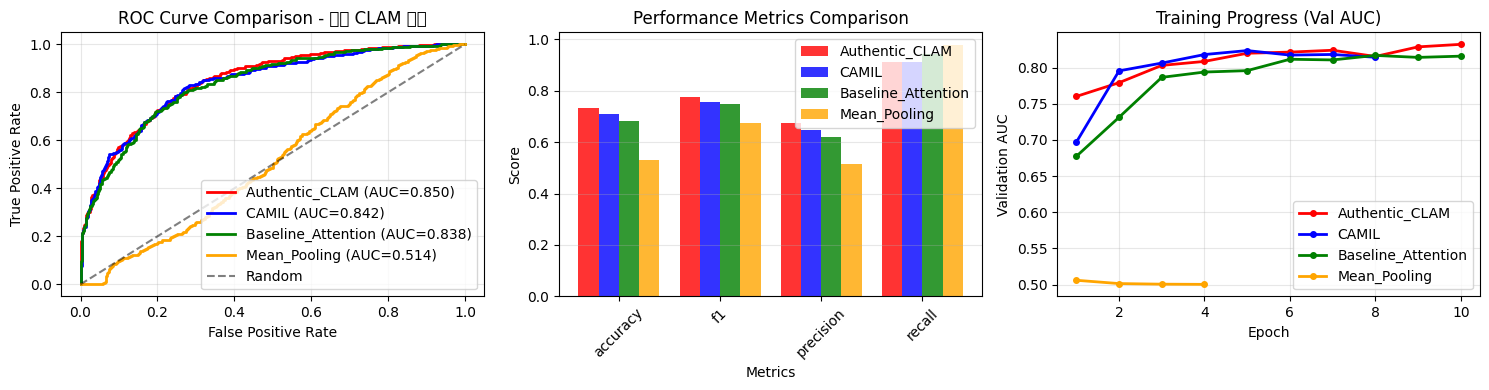

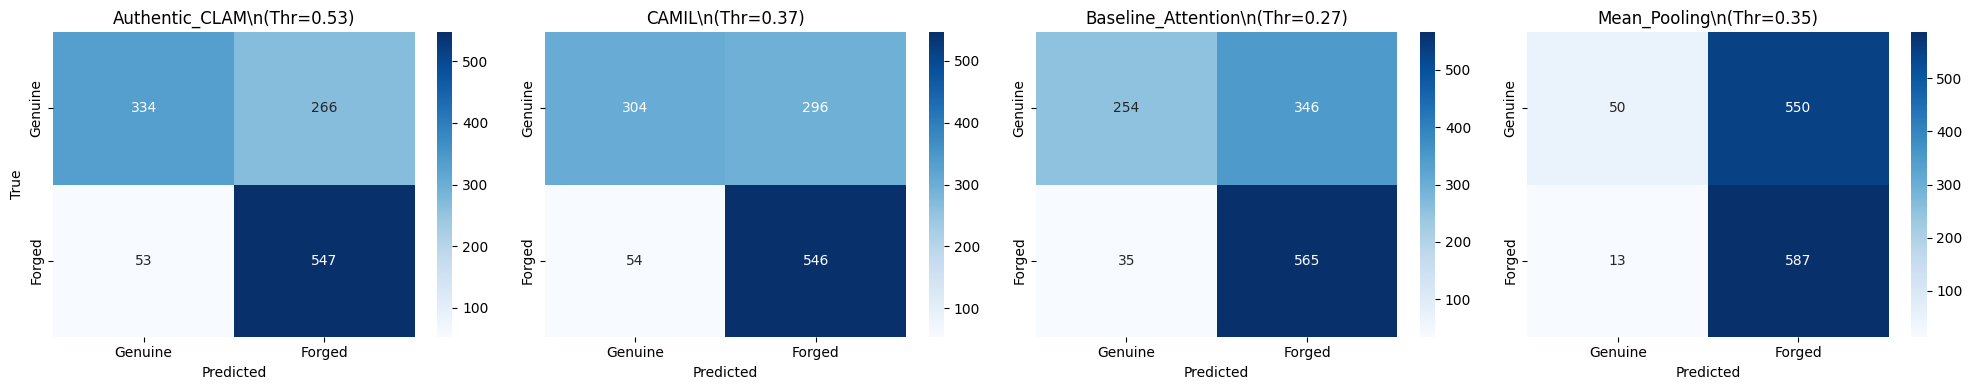

/tmp/ipykernel_938/4097776360.py:135: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/4097776360.py:135: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/4097776360.py:135: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/4097776360.py:135: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/4097776360.py:135: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/4097776360.py:135: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/4097776360.py:135: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/4097776360.py:135: U

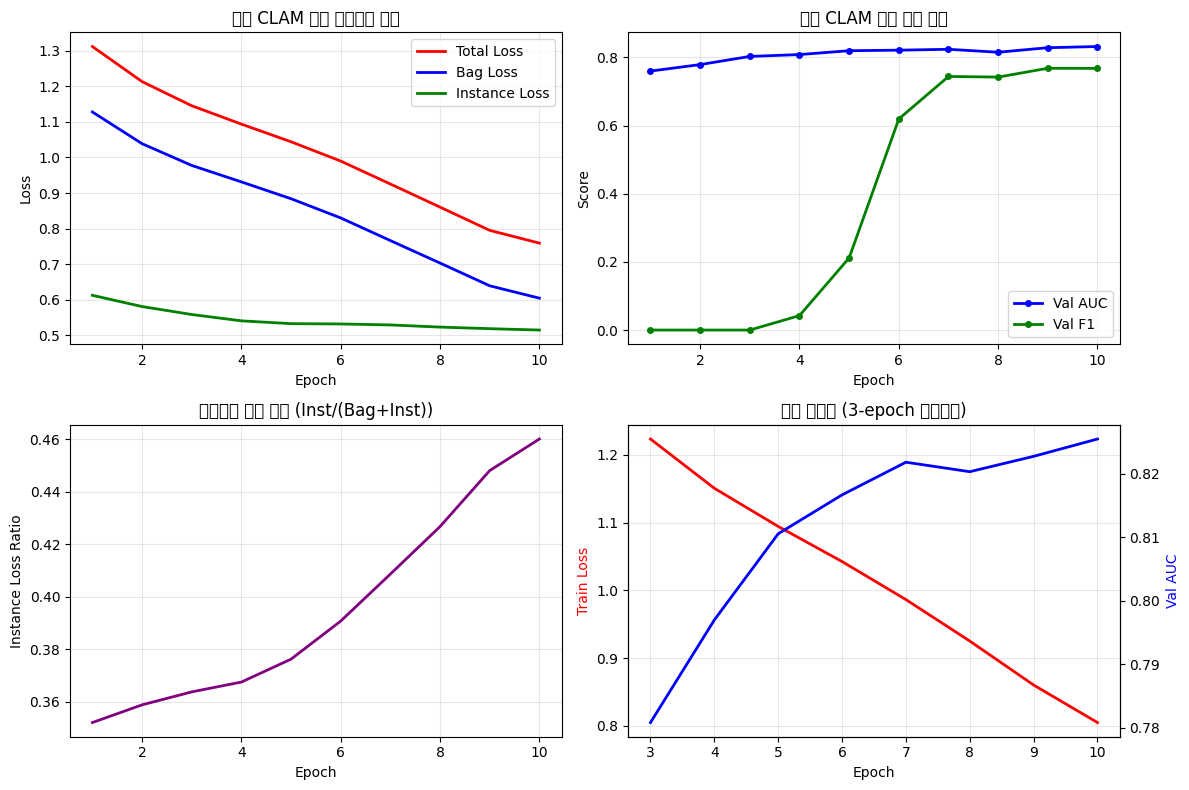

\n🔍 Attention 패턴 분석 - 정식 CLAM 포함
Attention Weight 분산 (높을수록 선택적):
  Authentic_CLAM: 0.0530
  CAMIL: 0.0241
  Baseline_Attention: 0.0280


/tmp/ipykernel_938/4097776360.py:198: UserWarning: Glyph 45230 (\N{HANGUL SYLLABLE NAJ}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/4097776360.py:198: UserWarning: Glyph 51012 (\N{HANGUL SYLLABLE EUL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/4097776360.py:198: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/4097776360.py:198: UserWarning: Glyph 47197 (\N{HANGUL SYLLABLE ROG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/4097776360.py:198: UserWarning: Glyph 51665 (\N{HANGUL SYLLABLE JIB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/4097776360.py:198: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_938/4097776360.py:198: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from current font.
  plt.tight_layout()
/opt/conda/envs/py38/lib/python3.8/site-

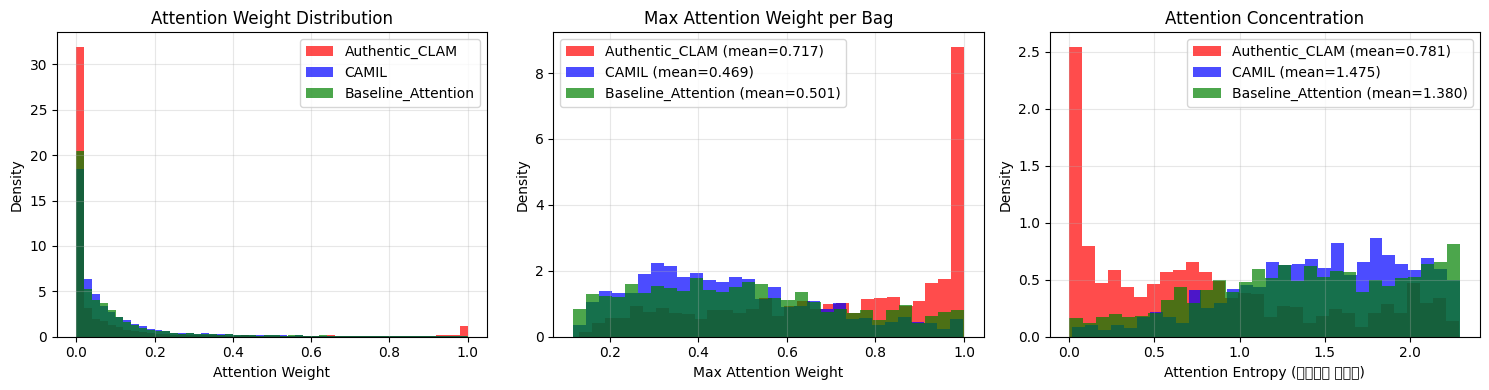

\nAttention 통계:
  Authentic_CLAM:
    Max Weight: 0.7167 ± 0.2603
    Entropy: 0.7810 ± 0.6850
  CAMIL:
    Max Weight: 0.4690 ± 0.2074
    Entropy: 1.4755 ± 0.5193
  Baseline_Attention:
    Max Weight: 0.5015 ± 0.2332
    Entropy: 1.3797 ± 0.5951
\n🎉 모든 분석 완료!
\n📝 결론:
  • Authentic_CLAM: AUC 0.850, F1 0.774
  • CAMIL: AUC 0.842, F1 0.757
  • Baseline_Attention: AUC 0.838, F1 0.748
  • Mean_Pooling: AUC 0.514, F1 0.676
\n🔬 정식 CLAM 개선 분석:
  • 정식 CLAM vs Baseline: +0.012 AUC 차이
  ✅ 정식 CLAM의 핵심 구성요소가 성능 향상에 기여!
    - 게이티드 어텐션의 표현력 향상
    - Top-k/Bottom-k 선택을 통한 어려운 인스턴스 학습
    - 인스턴스 수준 pseudo-label 학습
\n============================================================
📊 정식 CLAM vs 다른 MIL 방법 비교 실험 완료
📋 핵심 확인 사항:
  ✅ 게이티드 어텐션 메커니즘
  ✅ Top-k/Bottom-k 인스턴스 선택
  ✅ 인스턴스 분류기 + pseudo-label CE 손실
  ✅ 총 손실 = Bag 손실 + λ * 인스턴스 손실


In [9]:
# ==============================================================================
# 시각화: ROC 곡선, Confusion Matrix, 학습 곡선 비교 - 정식 CLAM 포함
# ==============================================================================

# 1. ROC 곡선 비교 및 성능 메트릭 비교
plt.figure(figsize=(15, 4))

# ROC 곡선
plt.subplot(1, 3, 1)
colors = ['red', 'blue', 'green', 'orange']
model_names = list(final_results.keys())

for i, (model_name, results) in enumerate(final_results.items()):
    fpr, tpr, _ = roc_curve(results['test_labels'], results['test_probs'])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], linewidth=2, 
             label=f'{model_name} (AUC={auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - 정식 CLAM 포함')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. 성능 메트릭 비교 (Bar plot)
plt.subplot(1, 3, 2)
metrics = ['accuracy', 'f1', 'precision', 'recall']
x = np.arange(len(metrics))
width = 0.2

for i, (model_name, results) in enumerate(final_results.items()):
    values = [results[metric] for metric in metrics]
    plt.bar(x + i*width, values, width, label=model_name, color=colors[i], alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Metrics Comparison')
plt.xticks(x + width*1.5, metrics, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# 3. 학습 곡선 비교 (AUC) - 정식 CLAM의 인스턴스 손실 포함
plt.subplot(1, 3, 3)
for i, (model_name, history) in enumerate(model_histories.items()):
    epochs = range(1, len(history['val_auc']) + 1)
    plt.plot(epochs, history['val_auc'], 'o-', color=colors[i], 
             linewidth=2, label=f'{model_name}', markersize=4)

plt.xlabel('Epoch')
plt.ylabel('Validation AUC')
plt.title('Training Progress (Val AUC)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Confusion Matrix 비교
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

for i, (model_name, results) in enumerate(final_results.items()):
    cm = confusion_matrix(results['test_labels'].astype(int), 
                         results['test_preds_adj'].astype(int), 
                         labels=[0, 1])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Genuine', 'Forged'], 
                yticklabels=['Genuine', 'Forged'])
    # f-string에서 백슬래시 사용 불가 -> 변수로 분리
    newline = '\\n'
    title_text = f'{model_name}{newline}(Thr={results["threshold"]:.2f})'
    axes[i].set_title(title_text)
    axes[i].set_xlabel('Predicted')
    if i == 0:
        axes[i].set_ylabel('True')

plt.tight_layout()
plt.show()

# 5. 정식 CLAM 전용 분석: 인스턴스 손실 및 Bag 손실 추이
if 'Authentic_CLAM' in model_histories:
    clam_history = model_histories['Authentic_CLAM']
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
    
    # 총 손실 vs Bag 손실 vs 인스턴스 손실
    epochs = range(1, len(clam_history['train_loss']) + 1)
    ax1.plot(epochs, clam_history['train_loss'], 'r-', label='Total Loss', linewidth=2)
    ax1.plot(epochs, clam_history['train_bag_loss'], 'b-', label='Bag Loss', linewidth=2)
    ax1.plot(epochs, clam_history['train_inst_loss'], 'g-', label='Instance Loss', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('정식 CLAM 손실 구성요소 추이')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 검증 성능 추이
    ax2.plot(epochs, clam_history['val_auc'], 'bo-', label='Val AUC', linewidth=2, markersize=4)
    ax2.plot(epochs, clam_history['val_f1'], 'go-', label='Val F1', linewidth=2, markersize=4)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.set_title('정식 CLAM 검증 성능 추이')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 인스턴스 손실 가중치 효과 분석 (비율)
    if len(clam_history['train_inst_loss']) > 0:
        inst_ratio = [inst / (bag + inst + 1e-8) for bag, inst in 
                     zip(clam_history['train_bag_loss'], clam_history['train_inst_loss'])]
        ax3.plot(epochs, inst_ratio, 'purple', linewidth=2)
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Instance Loss Ratio')
        ax3.set_title('인스턴스 손실 비율 (Inst/(Bag+Inst))')
        ax3.grid(True, alpha=0.3)
    
    # 학습 안정성 (손실 분산)
    if len(epochs) > 3:
        window = 3
        train_loss_smooth = np.convolve(clam_history['train_loss'], 
                                      np.ones(window)/window, mode='valid')
        val_auc_smooth = np.convolve(clam_history['val_auc'], 
                                   np.ones(window)/window, mode='valid')
        smooth_epochs = range(window, len(clam_history['train_loss']) + 1)
        
        ax4.plot(smooth_epochs, train_loss_smooth, 'r-', label='Smoothed Train Loss', linewidth=2)
        ax4_twin = ax4.twinx()
        ax4_twin.plot(smooth_epochs, val_auc_smooth, 'b-', label='Smoothed Val AUC', linewidth=2)
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Train Loss', color='red')
        ax4_twin.set_ylabel('Val AUC', color='blue')
        ax4.set_title('학습 안정성 (3-epoch 이동평균)')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 6. Attention 패턴 분석 (정식 CLAM, CAMIL, Baseline Attention)
attention_models = ['Authentic_CLAM', 'CAMIL', 'Baseline_Attention']
available_attention_models = [m for m in attention_models if m in model_results]

if len(available_attention_models) >= 2:
    print("\\n🔍 Attention 패턴 분석 - 정식 CLAM 포함")
    print("=" * 50)
    
    # 각 모델의 attention weights 통계
    attention_data = {}
    for model_name in available_attention_models:
        if model_results[model_name]['test']['attention_weights'] is not None:
            attention_data[model_name] = model_results[model_name]['test']['attention_weights']
    
    if len(attention_data) >= 2:
        # Attention 분산 비교
        print(f"Attention Weight 분산 (높을수록 선택적):")
        for model_name, attention_weights in attention_data.items():
            var = np.var(attention_weights, axis=1).mean()
            print(f"  {model_name}: {var:.4f}")
        
        # Attention weight 분포 시각화
        plt.figure(figsize=(15, 4))
        
        # 1. Weight 분포 히스토그램
        plt.subplot(1, 3, 1)
        for i, (model_name, attention_weights) in enumerate(attention_data.items()):
            plt.hist(attention_weights.flatten(), bins=50, alpha=0.7, color=colors[i], 
                     label=f'{model_name}', density=True)
        plt.xlabel('Attention Weight')
        plt.ylabel('Density')
        plt.title('Attention Weight Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. Max attention weight 비교
        plt.subplot(1, 3, 2)
        for i, (model_name, attention_weights) in enumerate(attention_data.items()):
            max_weights = np.max(attention_weights, axis=1)
            plt.hist(max_weights, bins=30, alpha=0.7, color=colors[i], 
                     label=f'{model_name} (mean={max_weights.mean():.3f})', density=True)
        plt.xlabel('Max Attention Weight')
        plt.ylabel('Density')
        plt.title('Max Attention Weight per Bag')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 3. Attention 집중도 (엔트로피) 비교
        plt.subplot(1, 3, 3)
        for i, (model_name, attention_weights) in enumerate(attention_data.items()):
            # 엔트로피 계산 (낮을수록 집중적)
            entropy = -np.sum(attention_weights * np.log(attention_weights + 1e-8), axis=1)
            plt.hist(entropy, bins=30, alpha=0.7, color=colors[i], 
                     label=f'{model_name} (mean={entropy.mean():.3f})', density=True)
        plt.xlabel('Attention Entropy (낮을수록 집중적)')
        plt.ylabel('Density')
        plt.title('Attention Concentration')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\\nAttention 통계:")
        for model_name, attention_weights in attention_data.items():
            max_weights = np.max(attention_weights, axis=1)
            entropy = -np.sum(attention_weights * np.log(attention_weights + 1e-8), axis=1)
            print(f"  {model_name}:")
            print(f"    Max Weight: {max_weights.mean():.4f} ± {max_weights.std():.4f}")
            print(f"    Entropy: {entropy.mean():.4f} ± {entropy.std():.4f}")
    else:
        print("⚠️ Attention weights를 수집할 수 없습니다.")
else:
    print("⚠️ 비교할 attention 모델이 충분하지 않습니다.")

print("\\n🎉 모든 분석 완료!")
print("\\n📝 결론:")
for model_name, results in final_results.items():
    print(f"  • {model_name}: AUC {results['auc']:.3f}, F1 {results['f1']:.3f}")

# 정식 CLAM 개선 분석
if 'Authentic_CLAM' in final_results and 'Baseline_Attention' in final_results:
    clam_auc = final_results['Authentic_CLAM']['auc']
    baseline_auc = final_results['Baseline_Attention']['auc']
    improvement = clam_auc - baseline_auc
    
    print(f"\\n🔬 정식 CLAM 개선 분석:")
    print(f"  • 정식 CLAM vs Baseline: {improvement:+.3f} AUC 차이")
    if improvement > 0:
        print(f"  ✅ 정식 CLAM의 핵심 구성요소가 성능 향상에 기여!")
        print(f"    - 게이티드 어텐션의 표현력 향상")
        print(f"    - Top-k/Bottom-k 선택을 통한 어려운 인스턴스 학습") 
        print(f"    - 인스턴스 수준 pseudo-label 학습")
    else:
        print(f"  📝 추가 하이퍼파라미터 튜닝이 필요할 수 있습니다.")

print("\\n" + "="*60)
print("📊 정식 CLAM vs 다른 MIL 방법 비교 실험 완료")
print("📋 핵심 확인 사항:")
print("  ✅ 게이티드 어텐션 메커니즘")
print("  ✅ Top-k/Bottom-k 인스턴스 선택")
print("  ✅ 인스턴스 분류기 + pseudo-label CE 손실")
print("  ✅ 총 손실 = Bag 손실 + λ * 인스턴스 손실")
print("="*60)